In [43]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import norm, skew #for some statistics

import statsmodels.formula.api as smf

In [44]:
#First, I need to Load the training and test data from Kaggle
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [45]:
#I think it is smart to start off getting rid of variables that have more than half of their data missing
train.dropna(thresh=int(len(train)*.5), axis=1, inplace =True)
test.dropna(thresh=int(len(train)*.5),axis =1, inplace = True)

In [46]:
#Now that any missing data is gone, I can check for skewness of SalePrice, the variable of interest
dropped = []
for i in train:
    if train[i].dtype =='object':
        if train[i].value_counts(normalize = True).iloc[0]>.6:
            print(train[i].value_counts(normalize= True))
            dropped.append(i)

RL         0.788356
RM         0.149315
FV         0.044521
RH         0.010959
C (all)    0.006849
Name: MSZoning, dtype: float64
Pave    0.99589
Grvl    0.00411
Name: Street, dtype: float64
Reg    0.633562
IR1    0.331507
IR2    0.028082
IR3    0.006849
Name: LotShape, dtype: float64
Lvl    0.897945
Bnk    0.043151
HLS    0.034247
Low    0.024658
Name: LandContour, dtype: float64
AllPub    0.999315
NoSeWa    0.000685
Name: Utilities, dtype: float64
Inside     0.720548
Corner     0.180137
CulDSac    0.064384
FR2        0.032192
FR3        0.002740
Name: LotConfig, dtype: float64
Gtl    0.946575
Mod    0.044521
Sev    0.008904
Name: LandSlope, dtype: float64
Norm      0.863014
Feedr     0.055479
Artery    0.032877
RRAn      0.017808
PosN      0.013014
RRAe      0.007534
PosA      0.005479
RRNn      0.003425
RRNe      0.001370
Name: Condition1, dtype: float64
Norm      0.989726
Feedr     0.004110
PosN      0.001370
RRNn      0.001370
Artery    0.001370
RRAn      0.000685
PosA      0.000

In [47]:
#I need to drop the columns that do not work
train.drop(dropped, axis = 1, inplace = True)
test.drop(dropped, axis =1, inplace =True)

In [48]:
#Now i want to get an idea for how big the remaining data is in the dataframe
print(train.shape)
print(test.shape)

(1460, 50)
(1459, 48)


In [49]:
#There are still some missing values, so to fill them in I will use the mean of the column as a substitute
train_full = train.fillna(train.mean()).round()
test_full = test.fillna(test.mean()).round()

Skew is: 1.8828757597682129


(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <a list of 10 Patch objects>)

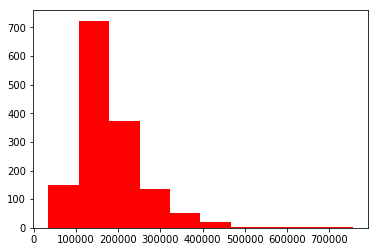

In [50]:
#Now I am ready to check the skewness of the SalePrice variable
print("Skew is:", train.SalePrice.skew())
plt.hist(train.SalePrice, color='red')

skew is: 0.12133506220520406


(array([  5.,  12.,  54., 184., 470., 400., 220.,  90.,  19.,   6.]),
 array([10.46024211, 10.7676652 , 11.07508829, 11.38251138, 11.68993448,
        11.99735757, 12.30478066, 12.61220375, 12.91962684, 13.22704994,
        13.53447303]),
 <a list of 10 Patch objects>)

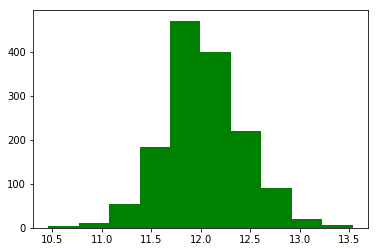

In [51]:
#We can see that sale price is positively skewed, so let's try to get more of a normal distribution
#I will do this by taking the log of the sale price

logsale = np.log(train.SalePrice)
print("skew is:", logsale.skew())
plt.hist(logsale, color='green')

In [52]:
#Now that the target variable SalePrice is transformed the way we want it to be,
#I want to see which variables are correlated with SalePrice

#First, I need to see what data type each variable in the dataset is
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [53]:
#now, I will see how correlated each of these variables is with SalePrice
corr = numeric_features.corr()

print(corr['SalePrice'].sort_values(ascending=False)[:20], '\n')
print(corr['SalePrice'].sort_values(ascending=False)[-20:])

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
Name: SalePrice, dtype: float64 

OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.08428

In [100]:
#the variables that are negatively correlated with SalePrice are not that negative, so I will not use them,
#as well as every positively correlated variable less than .35

#So now I will create new arrays with just the variables I plan on using in my model
train_final = train_full[['SalePrice','OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'Fireplaces', 'BsmtFinSF1']]
test_final = test_full[['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'Fireplaces', 'BsmtFinSF1']]

C:\Users\karla\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


IndexError: single positional indexer is out-of-bounds

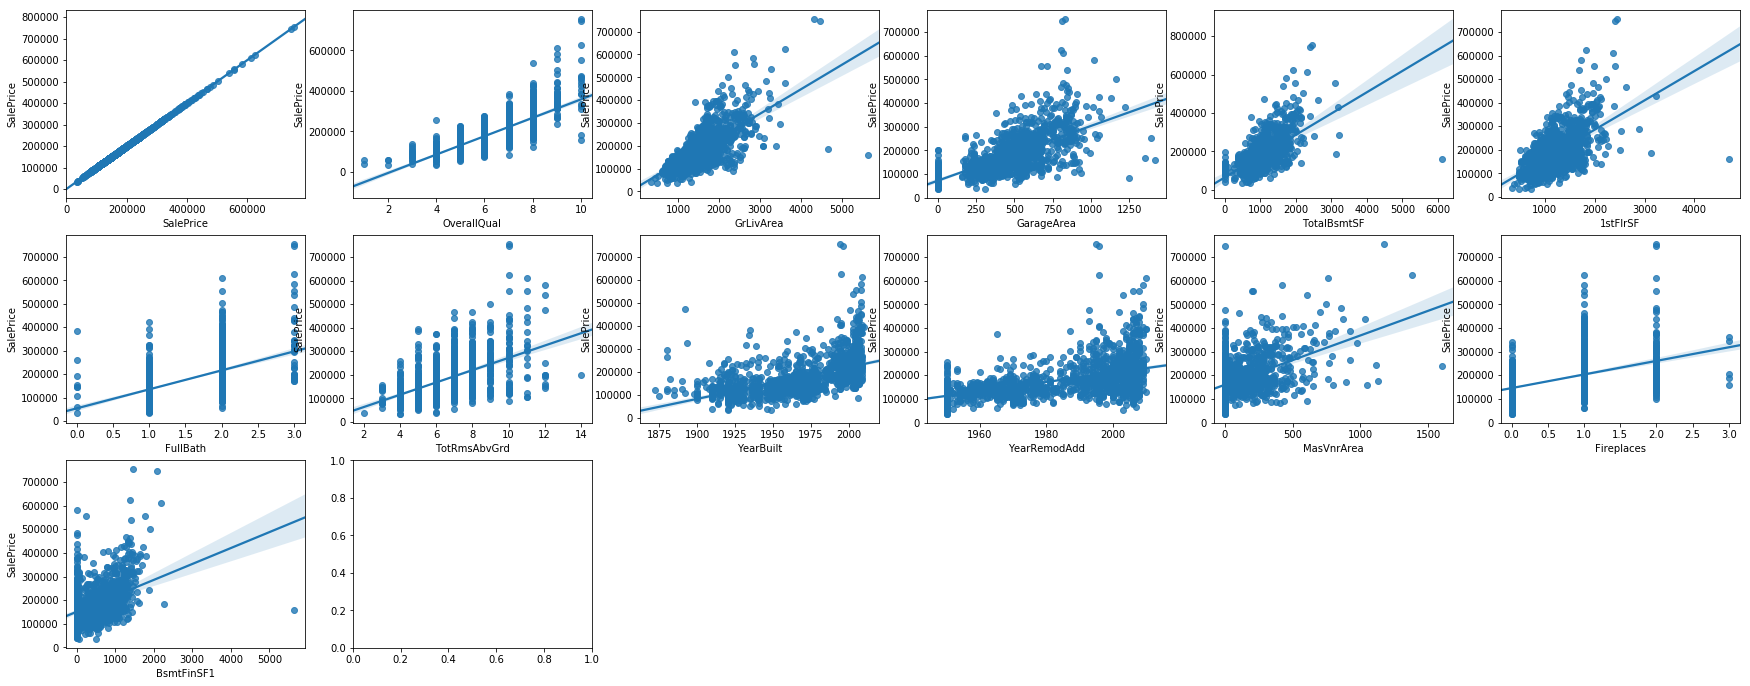

In [101]:
#Another very important step in cleaning the data is to make sure to get rid of any outliers
#I will make graphs for each variable in relation to SalePrice in order to see if there are outliers
outliers = train_final.select_dtypes(exclude = ['object'])


fig = plt.figure(figsize=(30,20))
for i in np.arange(29):
    ax = fig.add_subplot(5,6,i+1)
    sns.regplot(x=outliers.iloc[:,i], y=train_final['SalePrice'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Outliers Removed: SalePrice vs. All Variables", fontsize = 18)
plt.show()

In [102]:
#With the graphs, I can now estimate where the outliers are and drop them from both the training and test data

train_final = train_final.drop(train_final[(train_final['GrLivArea']>4000)].index)
train_final = train_final.drop(train_final[(train_final['BsmtFinSF1']>5000)].index)
train_final = train_final.drop(train_final[(train_final['TotalBsmtSF']>5000)].index)
train_final = train_final.drop(train_final[(train_final['1stFlrSF']>4000)].index)

test_final = test_final.drop(test_final[(test_final['GrLivArea']>4000)].index)
test_final = test_final.drop(test_final[(test_final['BsmtFinSF1']>5000)].index)
test_final = test_final.drop(test_final[(test_final['TotalBsmtSF']>5000)].index)
test_final = test_final.drop(test_final[(test_final['1stFlrSF']>4000)].index)

In [103]:
#Now that all the numeric variables are cleaned and accounted for, I need to create dummy variables
#for the categorical data
train_final2 = pd.get_dummies(train_full)
test_final2 = pd.get_dummies(test_full)

#I will also create the two dataframes I will be using in the model, the goal array I am aiming for
#and the prediction array that will do the heavy lifting
goal =(train_final['SalePrice'])
prediction = train_final.drop(['SalePrice'], axis=1)

In [104]:
#to get started with the various models, I need to split the data into sets for training and testing
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(prediction, goal, test_size=0.3, random_state = 42)

#I also need to scale the data so that the machine learning algorithms will work
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(prediction)
scale_train = scale.transform(prediction)
scale_test = scale.transform(test_final)

C:\Users\karla\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\karla\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
C:\Users\karla\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


In [105]:
#The first model I am trying is K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error

In [106]:
#With the necessary models imported, I can now cluster my data and run the regression to see how accurate my model is
reg = KNeighborsRegressor()
grid = GridSearchCV(reg, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='neg_mean_squared_error')
grid.fit(x_train, y_train)
print("Best Params: {}".format(grid.best_params_))
y_neighbor_train = grid.predict(x_train)
y_neighbor_test = grid.predict(x_test)
print("Train MSE: {}\tTest MSE: {}".format(mean_squared_error(y_train, y_neighbor_train),
                                           mean_squared_error(y_test, y_neighbor_test)))

C:\Users\karla\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best Params: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Train MSE: 84603.69430814523	Test MSE: 1321953187.3847868


C:\Users\karla\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [107]:
#The next model I will try using is Gradiant Descent
from sklearn.linear_model import SGDRegressor, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  GridSearchCV

In [108]:
linear_reg = SGDRegressor(tol=.0001, eta0=.01)
linear_reg.fit(x_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=0.0001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [109]:
train_gradiant = linear_reg.predict(x_train)
test_gradiant = linear_reg.predict(x_test)
print(train_gradiant)
print(test_gradiant)

[-3.45263536e+15 -3.70579290e+15 -3.52148859e+15 ... -3.57596361e+15
 -2.50841213e+15 -4.26345084e+15]
[-4.11057668e+15 -2.08110297e+15 -4.18880028e+15 -3.18899575e+15
 -2.64567571e+15 -2.41194244e+15 -4.83348131e+15 -3.42944414e+15
 -4.44055876e+15 -2.98418999e+15 -2.77965190e+15 -6.08498009e+15
 -2.99592020e+15 -1.50566912e+15 -2.09830878e+15 -1.77388142e+15
 -3.74527643e+15 -3.01994827e+15 -1.28655968e+15 -4.05375821e+15
 -3.18367063e+15 -2.96369139e+15 -2.10460041e+15 -3.09357925e+15
 -2.76968852e+15 -2.29139760e+15 -1.66876102e+15 -2.02001576e+15
 -2.45921557e+15 -1.52303357e+15 -2.79192815e+15 -4.81906152e+15
 -3.08895098e+15 -2.30013622e+15 -2.93189659e+15 -4.66075610e+15
 -4.05370268e+15 -3.57077469e+15 -5.12139194e+15 -2.65583022e+15
 -2.49133953e+15 -5.56658648e+15 -3.32399212e+15 -4.01326604e+15
 -1.27295317e+15 -3.56237759e+15 -4.54850016e+15 -3.60181181e+15
 -2.93360773e+15 -2.06075355e+15 -4.84427722e+15 -2.87069195e+15
 -2.53141259e+15 -3.13450090e+15 -1.54606322e+15 -4.

In [110]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_gradiant))
test_rmse = np.sqrt(mean_squared_error(y_test, test_gradiant))

print("Train RMSE: {}".format(train_rmse))
print("Test RMSE: {}".format(test_rmse))

Train RMSE: 3868131926247836.0
Test RMSE: 3781499611081903.0


In [111]:
#The last model I will try is Elastic Net
#This model will search and find the best values for L1 and alpha
from sklearn.linear_model import ElasticNetCV
clf = ElasticNetCV(l1_ratio=[.01,.005,.01,.1,.9,1,10],alphas = [.0001,.01,.1,10,100 ,1000], max_iter = 5000)
clf.fit(x_train, y_train)
print("Best Alpha: {}".format(clf.alpha_))
print("Best L1/L2 Ratio: {}".format(clf.l1_ratio_))
train_elastic = clf.predict(x_train)
test_elastic = clf.predict(x_test)

print("Train MSE: {}".format(mean_squared_error(y_train, train_elastic)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_elastic)))

Best Alpha: 0.1
Best L1/L2 Ratio: 0.9
Train MSE: 965666047.33252
Test MSE: 852876868.6823153


C:\Users\karla\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\karla\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\karla\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\karla\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase

In [113]:
#The lowest MSE from my three models was the k-nearest Neighbor
#thus, I am choosing to make my final prediction that i submit to kaggle my k-nearest neighbor predictions

neighbor_prediction = grid.predict(test_final)
neighbor_prediction_df = pd.DataFrame(neighbor_prediction)
neighbor_prediction_df.columns = [['SalePrice']]
print(neighbor_prediction)

[118427.96680554 177490.01019472 195365.47047756 ... 184525.94289361
 110002.70708598 252669.98750767]


In [ ]:
#Now I have to export my DataFrame in order to submit it to kaggle
excel = pd.ExcelWriter('house_prediction_neighbor.xlsx', engine = 'xlsxwriter')
neighbor_prediction_df.to_excel(excel, sheet_name='Sheet1')
excel.save()

In [120]:
#For some reason my dataframe dropped the Id for each house, so my submission was rejected
#I will go back to my original dataframe and create a new one that will keep the house Id numbers
test_id = test_full[['Id','OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'Fireplaces', 'BsmtFinSF1']]

test_id = test_id.drop(test_id[(test_id['GrLivArea']>4000)].index)
test_id = test_id.drop(test_id[(test_id['BsmtFinSF1']>5000)].index)
test_id = test_id.drop(test_id[(test_id['TotalBsmtSF']>5000)].index)
test_id = test_id.drop(test_id[(test_id['1stFlrSF']>4000)].index)

In [123]:
#Now I can export a finished csv that has both the house id numbers and my predicted Sale price
final = grid.predict(test_final)
ID = np.array(test_id['Id'],dtype=int)
final2 = pd.DataFrame({"ID":ID, "SalePrice":final})

final2.to_csv("kaggle_submission2", index=False)

In [ ]:
#After submitting my prediction to kaggle, I got a score of .20311, which was good enough for rank 3482